# Polynomial Regression
Let's now increase a bit the complexity of what we can predict.
We will have the same set up as in the linear regression, but this time the mapping between x and y is a polymomial expression:

 $y = ax^2 + bx$


Our classical imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as tfk

2024-08-19 16:19:50.592152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## We define the parameters of the polynomial expression:

In [2]:
a, b = 1, -1
sigma = 0.5

## Create the data points
With some noise

In [3]:

batch_size = 32
nb_batch = 400
xs = np.linspace(0, 4, batch_size*nb_batch)

rdms = np.random.normal(0, sigma, len(xs))
ys = (a * xs**2 + b*xs + rdms)


### and we can look at our data:

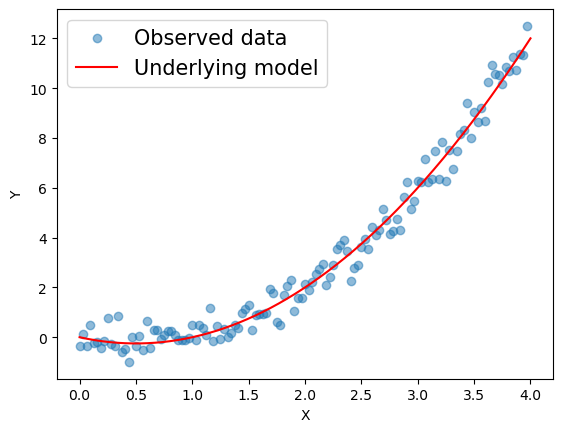

In [4]:
plt.scatter(xs[::100], ys[::100], alpha=0.5, label='Observed data',)
plt.plot(xs, a*xs**2 + b*xs, ls='-', marker='', c='red', label='Underlying model', alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(fontsize=15)

## Training set
We create the TensorFlow datasets, with a training set and a testing set.
As usual, we shuffle the xs and ys (witht the same order !), expand the dimesion ot get the feature dimension, and create the dataset `from_tensor_slices`

In [5]:
rdm_indices = np.random.choice(np.arange(0, len(xs)), len(xs))
xs_train = xs[rdm_indices][:int(0.8*len(xs))].astype('float32')
xs_train = np.expand_dims(xs_train, -1)
ys_train = ys[rdm_indices][:int(0.8*len(xs))].astype('float32')
ys_train = np.expand_dims(ys_train, -1)
training_set = tf.data.Dataset.from_tensor_slices((xs_train, ys_train)).batch(batch_size).shuffle(1000)

## Testing set
For an easy test, I use a big batch so I can just run one batch and see the results.

In [6]:
xs_test = xs[rdm_indices][int(0.8*len(xs)):].astype('float32')
xs_test = np.expand_dims(xs_test, -1)
ys_test = ys[rdm_indices][int(0.8*len(xs)):].astype('float32')
ys_test = np.expand_dims(ys_test, -1)
test_set = tf.data.Dataset.from_tensor_slices((xs_test, ys_test)).batch(200).shuffle(1000)

# print('Final shape of the training set', training_set.shape)

## Model
This time, to predict a non linear behaviour, we are going to complexify our model. We are still using dense layers, but we are going to have more depth and more nodes. We are also going to use an activation to add non linearity.
- more depth = multiple successive dense layers, the one taking into input the output of the previous one. because each layer is activated (adding non linearity), we can succesively gain non linearity after each layer.
- more nodes: each layers are more than one neuron (the number of output is called _units_ in keras), mulitpliying the number of features we can learn.

In [7]:
X = tfk.Input(shape=(1, 1), dtype=tf.float32)
y = tfk.layers.Dense(units=4, activation='relu')(X)
y = tfk.layers.Dense(units=8, activation='relu')(y)
Y = tfk.layers.Dense(units=1)(y)

model = tfk.Model(X, Y, name='model')
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 4)           │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1, 1)           │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57 (228.00 B)

 Trainable params: 57 (228.00 B)

 Non-trainable params: 0 (0.00 B)

### Our usual optimizer algorithm and loss:

In [8]:
optimizer = tfk.optimizers.RMSprop(learning_rate=5e-3)
loss_fn = tfk.losses.MSE

### Our usual training step

In [9]:
def train_model(X, Y, loss_fn):
    with tf.GradientTape() as tape:
        pred = model(X)
        loss = loss_fn(Y, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return pred, (np.mean(loss.numpy()))

### Our usual training loop
In addition, i append each input and prediction to a list to be able to plot the prediction during time (see the end of this notebook)

In [10]:
losses = []
nb_epochs = 20

train_y_history = []
train_x_history = []

for epoch in range(nb_epochs):
    print(f'Epoch {epoch}/{nb_epochs}')
    for i, (X, Y) in enumerate(training_set):
        pred, loss = train_model(X, Y, loss_fn)
        losses.append(loss)
        train_y_history.append(pred[:, 0, 0])
        train_x_history.append(X[:, 0])

2024-08-19 16:20:08.928505: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-19 16:20:19.380935: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-19 16:20:40.105994: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-08-19 16:21:23.586966: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Let's see how our loss evolved during training:

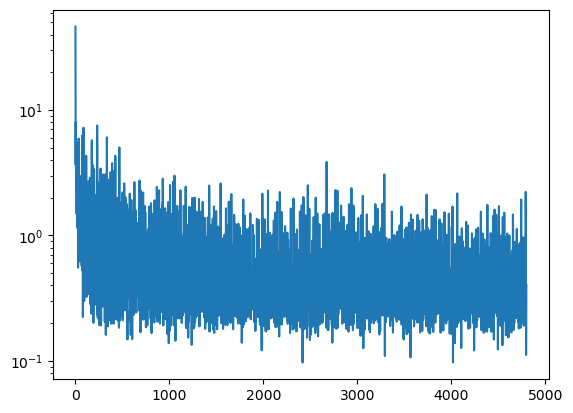

In [11]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(losses)), losses)
plt.yscale('log')

## Testing

Let's see how our model behaves in a batch of the testing set:

In [12]:
for i, (X, Y) in enumerate(test_set):
    if i > 0:
        break
    x_pred = X[:, 0]
    y_pred = model(X).numpy()[:, 0, 0]


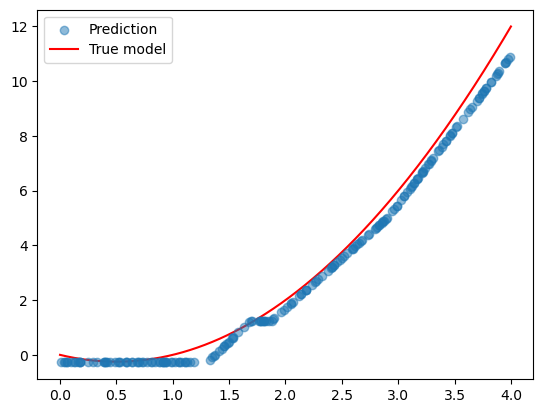

In [13]:
plt.scatter(x_pred, y_pred, alpha=0.5, label='Prediction')
plt.plot(xs, a * xs ** 2 + b * xs, ls='-', marker='', c='red', label='True model', alpha=1, zorder=0)
plt.legend()


# Visualising the training

I also show here how our model predicted during training, such that we can visualise how it evolved, getting closer to the truth:

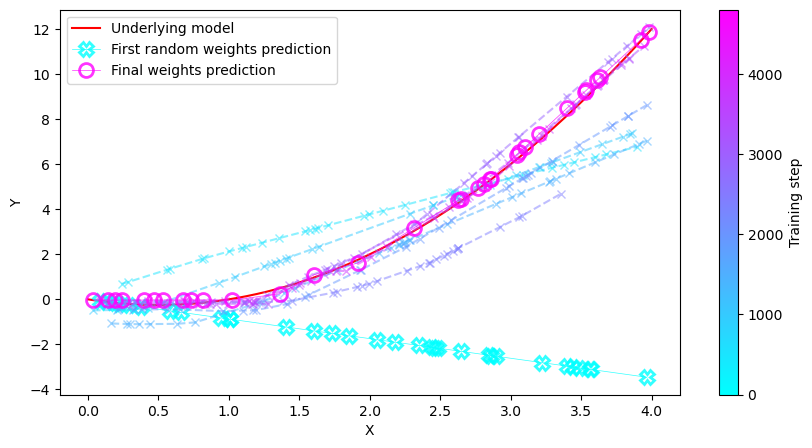

In [14]:

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize=(10, 5))
cmap = plt.cm.cool
cmaplist = [cmap(i) for i in range(cmap.N)]
n_plots = 10
cmap_index = np.linspace(1, cmap.N, n_plots+1).astype('int')

# Underlying model
ax.plot(xs, a * xs ** 2 + b * xs, ls='-', marker='', c='red', label='Underlying model', alpha=1, zorder=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Normalize for the colormap using the normal step values
norm = Normalize(vmin=0, vmax=np.shape(train_x_history)[0] - 1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Set the array to make ScalarMappable work

# First prediction
ordered_first_xs = np.argsort(train_x_history[0].numpy())
ax.plot(train_x_history[0].numpy()[ordered_first_xs],
        train_y_history[0].numpy()[ordered_first_xs],
        ls='-', color=cmaplist[-cmap_index[-1]], marker='X',
        markeredgewidth=2, markersize=10, markerfacecolor='none', label='First random weights prediction', lw=0.5, alpha=0.8)


for i, step in enumerate(np.logspace(0, np.log10(np.shape(train_x_history)[0] - 1), n_plots - 1).astype(int)):
    if i == 0:
        continue
    ordered_xs = np.argsort(train_x_history[step].numpy())
    # color = cmap(norm(step))
    ax.plot(train_x_history[step].numpy()[ordered_xs],
            train_y_history[step].numpy()[ordered_xs],
            ls='--', marker='x', c=cmaplist[cmap_index[i]], alpha=0.5)



# Final prediction
ordered_final_xs = np.argsort(train_x_history[-1].numpy())
ax.plot(train_x_history[-1].numpy()[ordered_final_xs],
        train_y_history[-1].numpy()[ordered_final_xs],
        ls='-', color=cmaplist[-cmap_index[0]], marker='o',
        markeredgewidth=2, markersize=10, markerfacecolor='none', label='Final weights prediction', lw=0.5, alpha=0.8)

# Adding the colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Training step')

plt.legend()
plt.show()
